In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
local = False
if local==True: sys.path.insert(1, '/Users/user/Documents/MeerKAT/meerpower/meerpower')
if local==False: sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot

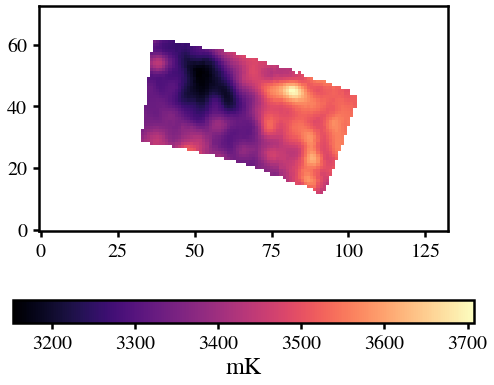

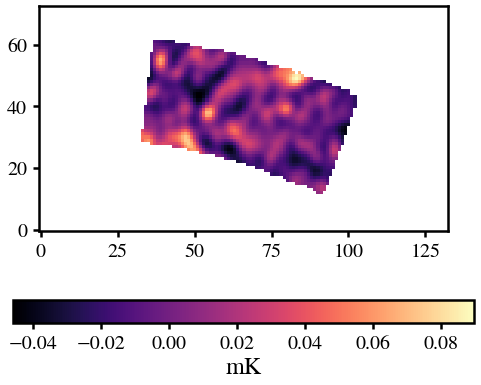

In [2]:
# Read-in level6 MeerKAT data:
if local==True: filestem = '/Users/user/Documents/MeerKAT/meerpower/localdata/'
if local==False: filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # tuned by eye in GAMA auto-corr
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
window = 'ngp'
compensate = True
interlace = True

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
raminMK,ramaxMK = 334,357
#decminMK,decmaxMK = -35,-26.5
decminMK,decmaxMK = np.min(dec[np.mean(W_HI,2)>0]),np.max(dec[np.mean(W_HI,2)>0])
MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)

### Use unit weights for mocks:
w_HI = np.ones(np.shape(MKmap)) # Not factorised along LoS so will add rank if used in foreground cleaning in current form

### Load in mock for example:
mockindx = np.random.randint(0, 499)
plot.Map(MKmap,W_HI)
MKmap = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%mockindx)
plot.Map(MKmap,W_HI)
plt.show()

2297
2269


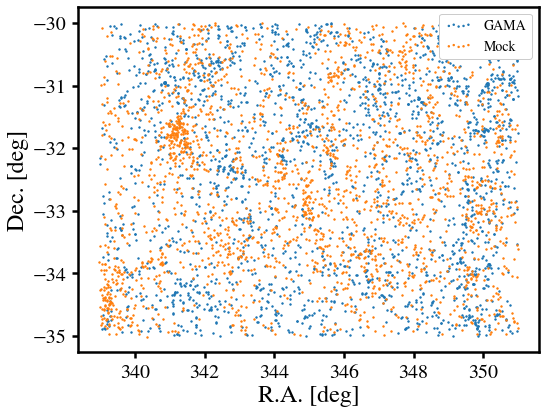

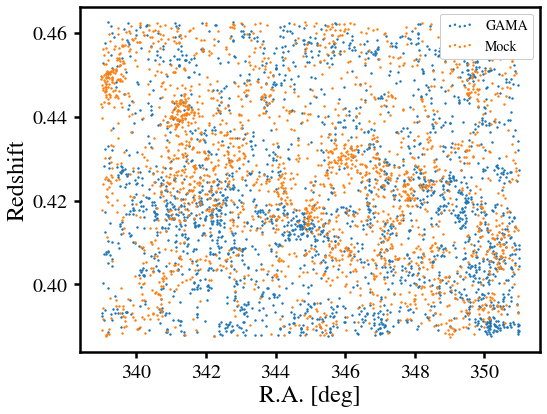

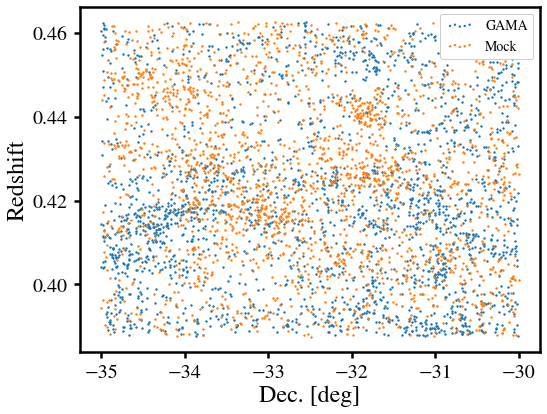

In [3]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
window = 'ngp'
compensate = True
interlace = False
nxmap,nymap,nzmap = np.shape(MKmap)
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
nzcell2vox = int(nzmap/cell2vox_factor)
if nzcell2vox % 2 != 0: nzcell2vox += 1 # Ensure z-dimension is even for FFT purposes
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),nzcell2vox
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI_untrim,dobuffer=True) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

### Load GAMA galaxies and compare to mocks:
from astropy.io import fits
Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
hdu = fits.open(Fits)
ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted
### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]
### Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA)
ra_g_GAMA,dec_g_GAMA,z_g_GAMA = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]
print(len(ra_g))
# Read-in GAMA mock galaxies:
ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%mockindx)
print(len(ra_g))
plt.scatter(ra_g_GAMA,dec_g_GAMA,s=2,label='GAMA')
plt.scatter(ra_g,dec_g,s=2,label='Mock')
plt.legend(fontsize=14,framealpha=1,loc='upper right')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')
plt.show()
plt.scatter(ra_g_GAMA,z_g_GAMA,s=2,label='GAMA')
plt.scatter(ra_g,z_g,s=2,label='Mock')
plt.legend(fontsize=14,framealpha=1,loc='upper right')
plt.xlabel('R.A. [deg]')
plt.ylabel('Redshift')
plt.show()
plt.scatter(dec_g_GAMA,z_g_GAMA,s=2,label='GAMA')
plt.scatter(dec_g,z_g,s=2,label='Mock')
plt.legend(fontsize=14,framealpha=1,loc='upper right')
plt.xlabel('Dec. [deg]')
plt.ylabel('Redshift')
plt.show()

# Regrid map, IM mask and weights to Cartesian field:
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_rg,null,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg,W_HI_rg,null = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)

# Grid galaxies straight to Cartesian field:
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)[0]

# Galaxy survey selection:
# grid uncut pixels to obtain binary mask in comoving space in absence of GAMA mocks for survey selection:
ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
'''
if doTrim==True:
    MKcutmask = (ra_p>ramin_gal) & (ra_p<ramax_gal) & (dec_p>decmin_gal) & (dec_p<decmax_gal)        
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
    null,W_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
'''
GAMAcutmask = (ra_p>raminGAMA) & (ra_p<ramaxGAMA) & (dec_p>decminGAMA) & (dec_p<decmaxGAMA)        
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[GAMAcutmask],dec_p[GAMAcutmask],HItools.Freq2Red(nu_p[GAMAcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W_g_rg,null = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
w_g_rg = np.copy(W_g_rg)

'''
# Create tapering to apply to Cartesian fields
# - needs to taper a conical footprint so currently using a technique that Gaussian smooths inwards from the empty edges:
doTaper = True # Implement apodisation window functions to apply to maps and weights to taper edges
if doTaper==True:
    # Gaussian smoothing from empty edges:
    taper_HI = np.copy(W01_HI_rg)
    taper_g = np.copy(W01_g_rg)
    from scipy.ndimage import gaussian_filter
    for i in range(8):
        taper_HI = gaussian_filter(taper_HI, sigma=1, mode='reflect')
        taper_HI[W01_HI_rg==0] = 0
        taper_g = gaussian_filter(taper_g, sigma=1, mode='reflect')
        taper_g[W01_g_rg==0] = 0

if doTaper==False: taper_HI,taper_g = 1,1
# Multiply tapering window by all galaxy fields that undergo Fourier transforms
W01_g_rg = taper_g*W01_g_rg
w_g_rg = np.ones((nx_rg,ny_rg,nz_rg))
w_g_rg = taper_g*w_g_rg
# HI window and weights:
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
# Multiply tapering window by all weights and window
w_HI_rg,W01_HI_rg = taper_HI*w_HI_rg,taper_HI*W01_HI_rg
'''

blackman = np.reshape( np.tile(np.blackman(nz_rg), (nx_rg,ny_rg)) , (nx_rg,ny_rg,nz_rg) ) # Blackman function along every LoS
w_HI_rg = blackman*w_HI_rg
w_g_rg = blackman*w_g_rg

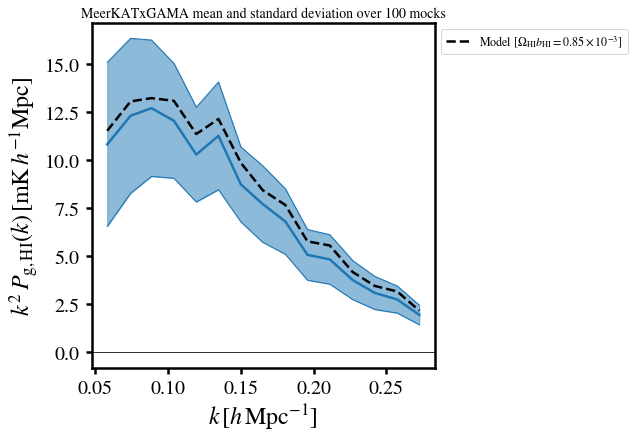

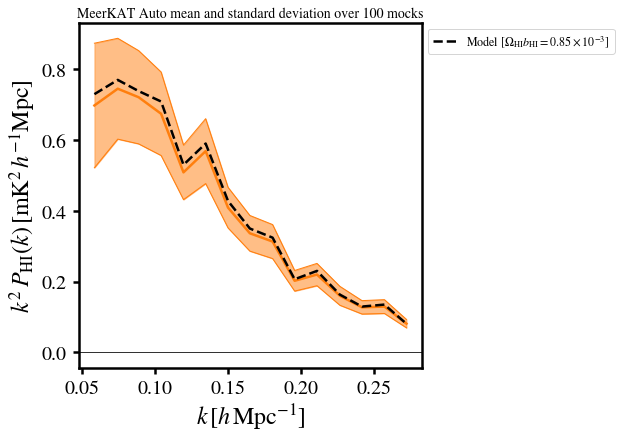

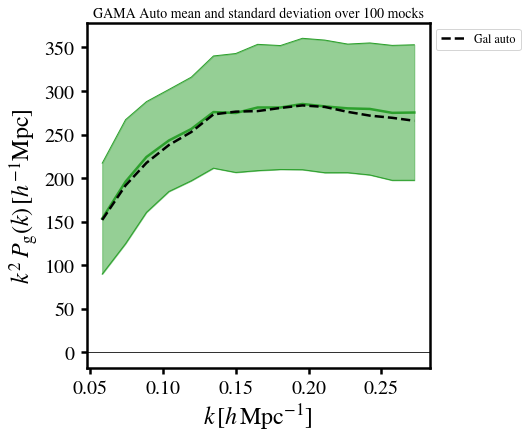

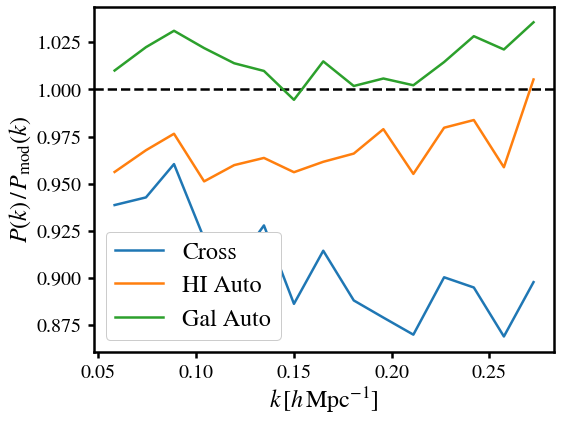

In [4]:
import power # All power spectrum calculations performed in this script
import model
from scipy import signal
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
nx,ny,nz = np.shape(MKmap)
kcuts = None # no cuts to k-space for power spectra estimation

'''
Nmock = 100
Pk_g,Pk_HI,Pk_X = np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin)),np.zeros((Nmock,nkbin))
for i in range(Nmock):
    plot.ProgressBar(i,Nmock)
    # Read-in GAMA mock galaxies:
    ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%i)
    ### Grid GAMA mock galaxies and measure power:
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
    n_g_rg,W_fft,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)
    #n_g_rg = taper_g*n_g_rg
    Pk_g[i],k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W_g_rg,W2=W_g_rg)

    # Read-in HI IM mock:
    MKmap = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%i)
    # Resample HI IM mock and measure power and cross power:
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)
    #MKmap_rg = taper_HI*MKmap_rg # multiply tapering window by HI map
    Pk_HI[i],k,nmodes = power.Pk(MKmap_rg,MKmap_rg,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W_HI_rg,W2=W_HI_rg,kcuts=kcuts)
    Pk_X[i],k,nmodes = power.Pk(MKmap_rg,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=W_g_rg,W1=W_HI_rg,W2=W_g_rg,kcuts=kcuts)

#np.save('/idia/projects/hi_im/meerpower/2021Lband/mocks/PksFromMocks',[Pk_HI,Pk_g,Pk_X,k])
'''
Pk_HI,Pk_g,Pk_X,k = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/PksFromMocks.npy',allow_pickle=True)

sig_v = 300
b_HI = 1.5
b_g = 2.35 # tuned by eye in GAMA auto-corr

Nmock = np.shape(Pk_HI)[0]
norm = k**2
#norm = np.ones(nkbin)

### Cross-correlation:
plt.plot(k,norm*np.mean(Pk_X,0),color='tab:blue')
plt.plot(k,norm*(np.mean(Pk_X,0)-np.std(Pk_X,0)),lw=1,color='tab:blue')
plt.plot(k,norm*(np.mean(Pk_X,0)+np.std(Pk_X,0)),lw=1,color='tab:blue')
plt.fill_between(k,norm*(np.mean(Pk_X,0)-np.std(Pk_X,0)),norm*(np.mean(Pk_X,0)+np.std(Pk_X,0)), alpha=0.5, color='tab:blue')
#plt.errorbar(k,norm*np.mean(Pk_X,0),norm*np.std(Pk_X,0),ls='none',marker='o')
# Model power spectrum:
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam,R_beam2=0,w1=W_HI_rg,w2=W_g_rg,W1=W_HI_rg,W2=W_g_rg,s_pix1=s_pix,s_pix2=0,s_para1=s_para,s_para2=0,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
if norm[0]==1.0: plt.loglog()
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
if norm[0]!=1.0: plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
plt.title(r'MeerKATxGAMA mean and standard deviation over %s mocks'%Nmock,fontsize=14)
plt.show()

### HI auto
plt.plot(k,norm*np.mean(Pk_HI,0),color='tab:orange')
plt.plot(k,norm*(np.mean(Pk_HI,0)-np.std(Pk_HI,0)),lw=1,color='tab:orange')
plt.plot(k,norm*(np.mean(Pk_HI,0)+np.std(Pk_HI,0)),lw=1,color='tab:orange')
plt.fill_between(k,norm*(np.mean(Pk_HI,0)-np.std(Pk_HI,0)),norm*(np.mean(Pk_HI,0)+np.std(Pk_HI,0)), alpha=0.5, color='tab:orange')
pkmod_HI,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_HI,f,sig_v,Tbar1=Tbar,Tbar2=Tbar,r=1,R_beam1=R_beam,R_beam2=R_beam,w1=W_HI_rg,w2=W_HI_rg,W1=W_HI_rg,W2=W_HI_rg,s_pix1=s_pix,s_pix2=s_pix,s_para1=s_para,s_para2=s_para,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod_HI,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
if norm[0]==1.0: plt.loglog()
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm HI}(k)\,[{\rm mK}^2\,h^{-1}{\rm Mpc}]$')
if norm[0]!=1.0: plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
plt.title(r'MeerKAT Auto mean and standard deviation over %s mocks'%Nmock,fontsize=14)
plt.show()

plt.plot(k,norm*np.mean(Pk_g,0),color='tab:green')
plt.plot(k,norm*(np.mean(Pk_g,0)-np.std(Pk_g,0)),lw=1,color='tab:green')
plt.plot(k,norm*(np.mean(Pk_g,0)+np.std(Pk_g,0)),lw=1,color='tab:green')
plt.fill_between(k,norm*(np.mean(Pk_g,0)-np.std(Pk_g,0)),norm*(np.mean(Pk_g,0)+np.std(Pk_g,0)), alpha=0.5, color='tab:green')
pkmod_g,k = model.PkMod(Pmod,dims_rg,kbins,b_g,b_g,f,sig_v,Tbar1=1,Tbar2=1,r=1,R_beam1=0,R_beam2=0,w1=W_g_rg,w2=W_g_rg,W1=W_g_rg,W2=W_g_rg,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod_g,color='black',ls='--',label='Gal auto')
if norm[0]==1.0: plt.loglog()
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g}(k)\,[h^{-1}{\rm Mpc}]$')
if norm[0]!=1.0: plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
plt.title(r'GAMA Auto mean and standard deviation over %s mocks'%Nmock,fontsize=14)
plt.show()

plt.axhline(1,ls='--',color='black')
plt.plot(k,np.mean(Pk_X,0)/pkmod,label='Cross')
plt.plot(k,np.mean(Pk_HI,0)/pkmod_HI,label='HI Auto')
plt.plot(k,np.mean(Pk_g,0)/pkmod_g,label='Gal Auto',color='tab:green')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P(k)\,/\,P_{\rm mod}(k)$')
plt.legend(framealpha=1)
plt.show()
